In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [33]:
round_split = re.compile("\n\n")#("(### Batch [0-9]+)")
space_split = re.compile("( |\n)")#("(### Batch [0-9]+)")
run_split = re.compile("\+\+\+\+\+\+\+\+\+\+\+\+\+\+\+\n")

round_find = re.compile("rounds = .+?\n")
chain_num_find = re.compile("\[Chain\] # =.+?\n")
cluster_num_find = re.compile("\[CLINK\] Comp Num =.+?\n")

avg_used_cache_find = re.compile("avg-used-cache:.+?\n")
max_used_cache_find = re.compile("max-used-cache:.+?\n")

distance_computed_find = re.compile("distance-computed:.+?\n")
points_in_range_find = re.compile("points-in-range:.+?\n")




def get_perf_stats(file):
    f1 = open(file)  
    data1 = f1.read()
    num_runs = 1
#     if thread == 1:
#         num_runs = 1
    
    runs = run_split.split(data1) #runs[1:1+num_runs] are the three runs
    round_num = int(round_find.findall(runs[1])[0][9:])

    rounds = round_split.split(runs[1])
    stats = {}
    stats["cluster_nums"] = []
    stats["chain_nums"] = []
    stats["cc"] = []
    stats["avg_used_cache"] = []
    stats["max_used_cache"] = []
    stats["distance_computed"] = []
    stats["points_in_range"] = []
    stats["distance_computed_per"] = []
    stats["points_in_range_per"] = []
    
    
    # start from the second round
    for i in range(2,len(rounds)):
        chain_num = int(chain_num_find.findall(rounds[i])[0][12:])
        cluster_num = int(cluster_num_find.findall(rounds[i])[0][19:])
        if(cluster_num <= 5):
            break
        
        avg_cache = float(avg_used_cache_find.findall(rounds[i])[0][16:])
        max_cache = float(max_used_cache_find.findall(rounds[i])[0][16:])
        distance_computed = float(distance_computed_find.findall(rounds[i])[0][18:])
        points_in_range = float(points_in_range_find.findall(rounds[i])[0][16:])
        
        stats["cluster_nums"].append(cluster_num)
        stats["chain_nums"].append(chain_num)
        stats["cc"].append(chain_num * cluster_num)
        stats["avg_used_cache"].append(avg_cache)
        stats["max_used_cache"].append(max_cache)
        stats["distance_computed"].append(distance_computed)
        stats["points_in_range"].append(points_in_range)
        stats["distance_computed_per"].append(distance_computed/(chain_num*cluster_num))
        stats["points_in_range_per"].append(points_in_range/(chain_num*cluster_num))
    return stats

In [119]:
datasets = [    "10D_UCI4_100K" ,\
        "10D_UCI1_19K" ,\
        "2D_GaussianDisc_10K",\
        "2D_UniformFill_1M",\
        "2D_GaussianDisc_1M",\
        "5D_UniformFill_1M",\
        "5D_GaussianDisc_1M",\
        "2D_UniformFill_10M",\
        "2D_GaussianDisc_10M",\
        "5D_UniformFill_10M",\
        "5D_GaussianDisc_10M",\
        "3D_GeoLife_24M",\
        "HT",\
        "CHEM"]

sizes = [100000, 19020, 10000, 1e6, 1e6, 1e6, 1e6, 1e7,1e7, 1e7, 1e7, 24876978, 928991, 4208261]

In [34]:
np.sum(stats["cluster_nums"]) 

21448065

In [114]:
max_avg = []
max_max = []
dist_per = []
pts_per = []
cc_sum = []
dists = []
pts = []
for dataset in datasets:
    file = "/Users/sy/Desktop/MIT/HAC/parChain/outputs/stats_outputs_avg128/stats_avg128_%s_96th.txt" % dataset
    if dataset == "3D_GeoLife_24M":
        file = "/Users/sy/Desktop/MIT/HAC/parChain/outputs/stats_avg64_%s_96th.txt" % dataset
    stats = get_perf_stats(file)
    max_avg.append(max(stats["avg_used_cache"]))
    max_max.append(max(stats["max_used_cache"]))
    dist_per.append(np.sum(stats["distance_computed"]) / np.sum(stats["cc"]))
    pts_per.append(np.sum(stats["points_in_range"])/ np.sum(stats["cc"]))
    dists.append(np.sum(stats["distance_computed"]))
    pts.append(np.sum(stats["points_in_range"]))
    cc_sum.append(np.sum(stats["cc"]))

/Users/sy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/sy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/sy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[1.98318676 0.22801384]


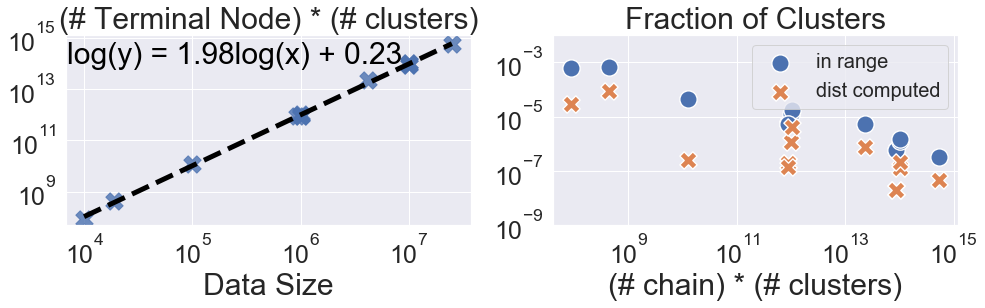

In [256]:
sns.set(font_scale=1.6)
fontsize = 30
markersize = 300

fig, axs = plt.subplots(1, 2, figsize =(16,3.5))

axs[0], axs[1] = axs[1], axs[0]

sns.scatterplot( cc_sum , pts_per, s = markersize, label = "in range", ax = axs[0])
sns.scatterplot( cc_sum, dist_per, s = markersize, label = "dist computed", ax = axs[0], marker = "X")
axs[0].set_ylim(1e-9,1e-2)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
# plt.legend()
axs[0].set_xlabel("(# chain) * (# clusters)", fontsize = fontsize)
axs[0].set_title("Fraction of Clusters", fontsize = fontsize)
axs[0].legend(fontsize = 20, loc = "upper right")


print(np.polyfit(np.log(sizes), np.log(cc_sum), deg = 1))
sns.lineplot(sizes, np.exp(1.98318676 * np.log(sizes) + 0.22801384), ax = axs[1], 
             color = "black", linewidth = 5, linestyle = "--")
axs[1].scatter(sizes, cc_sum, s = markersize, alpha = 0.8, marker = "X" )

axs[1].text(1e4-3000, 1e14, "log(y) = 1.98log(x) + 0.23", color = "black", fontsize = fontsize)

# sns.scatterplot(sizes, dists, s = 80, label = "dist computed")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Data Size", fontsize = fontsize)
axs[1].set_title("(# Terminal Node) * (# clusters)", fontsize = fontsize)


# sns.scatterplot(max_avg, max_max, s = markersize, ax = axs[2])
# x_move = 3
# for i in range(len(max_avg)):
#     label = datasets[i].replace("GaussianDisc", "G").replace("UniformFill", "U").replace("_", "-")
#     x=max_avg[i]+3
#     y=max_max[i]
#     if("2D" in label and "M" in label):
#         x=max_avg[i]+x_move
#         x_move += 15
#     elif("3D-Geo" in label):
#         label = label + " (cache=128)"
#         x=max_avg[i]+3
#     axs[2].text(x=x, y=y, s=label, rotation = -10, fontsize = 20)

# axs[2].set_xlabel("(c) Max. Avg. Cache Used", fontsize = fontsize)
# axs[2].set_ylabel("Max. Cache Used", fontsize = fontsize)


for ax in axs:
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(25)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(25)

axs[0].grid(b=True, which='major', linestyle='-')
axs[1].grid(b=True, which='major', linestyle='-')
# axs[2].grid(b=True, which='major', linestyle='-')

# plt.subplots_adjust(left=0.045,right=0.995,bottom=0.1,top=0.83,wspace=0.3,hspace=0.3)
plt.savefig("/Users/sy/Desktop/MIT/HAC/hac_paper/revision/figures/exp_optimizations.pdf", bbox_inches = 'tight', pad_inches = 0.1)

/Users/sy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


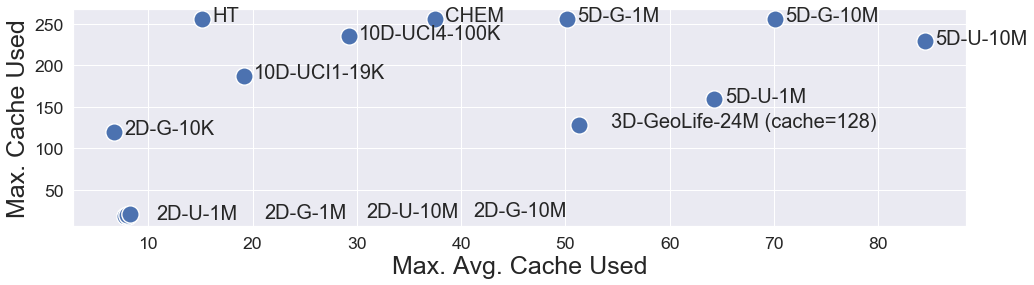

In [241]:
sns.set(font_scale=1.6)
fontsize = 25

fig, ax = plt.subplots(1, 1, figsize =(16,4))
sns.scatterplot(max_avg, max_max, s = 300, ax= ax)
x_move = 3
for i in range(len(max_avg)):
    label = datasets[i].replace("GaussianDisc", "G").replace("UniformFill", "U").replace("_", "-")
    x=max_avg[i]+1
    y=max_max[i]-3
    if("2D" in label and "M" in label):
        x=max_avg[i]+x_move
        x_move += 10
    elif("3D-Geo" in label):
        label = label + " (cache=128)"
        x=max_avg[i]+3
    ax.text(x=x, y=y, s=label, rotation = 0, fontsize = 20)
# plt.xscale("log")
# plt.yscale("log")
# yticks = np.arange(ybottomlog, ytoplog+(ytoplog-ybottomlog)/5, 1)
# myax.set_yticks(np.power(10, yticks))
ax.set_xlabel("Max. Avg. Cache Used", fontsize = fontsize)
ax.set_ylabel("Max. Cache Used", fontsize = fontsize)
plt.savefig("/Users/sy/Desktop/MIT/HAC/hac_paper/revision/figures/exp_cache_usage.pdf", bbox_inches = 'tight', pad_inches = 0.1)

The cache usage when running on 48 cores with two-way hyperthreading. x-axis is the $\max_{r \in \text{rounds}}(\text{avg}_{C \in clusters} \text{cache used by C in round r})$, y-axis is $\max_{r \in \text{rounds}, C \in \text{clusters}}(\text{cache used by C in round r})$. $s = 256$ for all clusters except GeoLife($s=128$) because of memory limit.

We see 5 datasets reach the memory limit. Higher dimension and larger datasets use more cache. The average cache usage is all less than 80. So in our experiments, we choose 64 for memory and speed test. Figure 4 shows that indeed using caches larger than the average cache usage does not improve the performance much. If the cache used is too large, it might create too much overhead because when merging two clusters, we need to scan all cache slots regardless of the cache usage.

In [94]:
max(dist_per), max(pts_per)

(8.930116756581224e-05, 0.0006741275919038029)

In [96]:
min(dist_per), min(pts_per)

(1.9465607717669484e-08, 3.1916017719173307e-07)

/Users/sy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/sy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Total # of clusters')

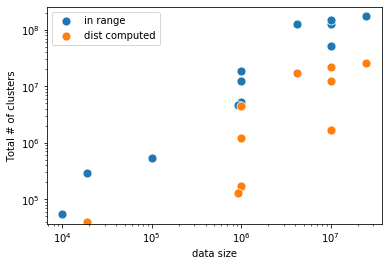

In [157]:
sns.scatterplot(sizes , pts, s = 80, label = "in range")
sns.scatterplot(sizes, dists, s = 80, label = "dist computed")
# plt.ylim(1e-9,1e-2)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("data size")
plt.ylabel("Total # of clusters")

array([1.98318676, 0.22801384])